In [ ]:
import os  # 导入操作系统模块
import numpy as np  # 导入numpy库并使用别名np
import cv2  # 导入OpenCV库
import matplotlib.pyplot as plt  # 导入matplotlib库并使用别名plt
import scipy  # 导入scipy库
from sklearn.neighbors import KNeighborsClassifier  # 从sklearn.neighbors模块导入KNeighborsClassifier类
import warnings  # 导入警告模块
warnings.simplefilter("ignore")  # 忽略警告

#************************************************************************************
# 读取图像数据
def read_images():
    file_name = "att_faces"  # 数据集文件夹名称
    data_directory = ""+file_name  # 数据集所在目录路径
    
    data = np.zeros((400,10304))  # 存储图像数据的数组
    labels = np.zeros((400,1))  # 存储标签的数组
    
    i=0  # 计数器
    for name in os.listdir(data_directory):  # 遍历数据集文件夹中的文件
        folderPath = os.path.join(data_directory,name)  # 拼接文件夹路径
        for ImageName in os.listdir(folderPath):  # 遍历每个文件夹中的图像文件
            Image_path = os.path.join(folderPath,ImageName)  # 拼接图像文件路径
            
            img = cv2.imread(Image_path,0)  # 读取灰度图像
            data[i,:] = img.flatten()  # 将图像展平并存储到data数组中
            labels[i] =  int(name)  # 将标签存储到labels数组中
            i+=1  # 计数器自增
    return data, labels  # 返回图像数据和标签

#************************************************************************************
    
# 训练集和测试集划分
def train_test_split(data, labels):
    train_split_value = int(data.shape[0]*(5/10))  # 训练集大小
    test_split_value = data.shape[0] - train_split_value  # 测试集大小
    
    train_data = np.zeros((train_split_value,10304))  # 存储训练集图像数据的数组
    train_labels = np.zeros((train_split_value,1))  # 存储训练集标签的数组
    
    test_data = np.zeros((test_split_value,10304))  # 存储测试集图像数据的数组
    test_labels = np.zeros((test_split_value,1))  # 存储测试集标签的数组
    
    # 奇数行用于训练数据，偶数行用于测试数据
    i_train=0  # 训练数据计数器
    i_test=0  # 测试数据计数器
    for i in range(data.shape[0]):  # 遍历所有数据
        # 偶数行
        if i%2==0:  # 判断是否为偶数行
           test_data[i_test,:] = data[i]  # 将当前图像存储到测试数据数组中
           test_labels[i_test] = labels[i]  # 将当前标签存储到测试标签数组中
           i_test+=1  # 测试数据计数器自增
        # 奇数行
        else:
           train_data[i_train,:] = data[i]  # 将当前图像存储到训练数据数组中
           train_labels[i_train] = labels[i]  # 将当前标签存储到训练标签数组中
           i_train+=1  # 训练数据计数器自增
           
    return train_data, train_labels, test_data, test_labels  # 返回训练集和测试集数据及标签

#************************************************************************************  
    
# 计算每个类别的均值矩阵
def compute_classes_mean_matrix(train_data, train_labels):
    means = np.zeros((40,10304))  # 存储每个类别的均值矩阵
    train_test_split_ratio = 5  # 训练集与测试集的比例
    
    for i in range(1, 41):  # 遍历每个类别
        temp = np.where(train_labels == i)[0]  # 获取当前类别的训练数据索引
        temp_sum = np.zeros((1,10304))  # 存储当前类别的像素总和
        for j in range(train_test_split_ratio):  # 遍历当前类别的训练数据
           temp_sum += train_data[temp[j],:]  # 累加像素值
            
        means[i-1,:] = temp_sum / train_test_split_ratio  # 计算当前类别的均值
    return means  # 返回每个类别的均值矩阵

#************************************************************************************
    
# 计算所有类别的整体均值矩阵
def compute_overall_mean_matrix(classes_means):
    temp_sum = np.zeros((1,10304))  # 存储像素总和
    for i in range(0,40):  # 遍历每个类别的均值矩阵
        temp_sum += classes_means[i,:]  # 累加像素值
    overall_mean = temp_sum / 40  # 计算整体均值
    
    return overall_mean.T  # 返回整体均值矩阵的转置

#************************************************************************************
    
# 计算类间散布矩阵
def compute_between_class_scatter_matrix(classes_means, overall_mean):
    n = 5  # 训练集与测试集的比例
    Sb = np.zeros((classes_means.shape[1], classes_means.shape[1]))  # 初始化类间散布矩阵
    for i in range(classes_means.shape[0]):  # 遍历每个类别的均值矩阵
        Sb = np.add(Sb, n * ((classes_means[i] - overall_mean) * (classes_means[i] - overall_mean).T))  # 计算类间散布矩阵
    return Sb  # 返回类间散布矩阵

#************************************************************************************
    
# 计算中心类别矩阵
def compute_center_class_matrix(train_data, train_labels, classes_means):
    Z = np.zeros(train_data.shape)  # 初始化中心类别矩阵
    
    for i in range(train_data.shape[0]):  # 遍历训练数据
        Z[i,:] = train_data[i,:] - classes_means[int(train_labels[i])-1,:]  # 计算中心类别矩阵

    return Z  # 返回中心类别矩阵

#************************************************************************************
    
# 计算类内散布矩阵
def compute_class_scatter_matrix(Z):
    S = np.zeros((10304, 10304))  # 初始化类内散布矩阵
    S = np.dot(Z.T, Z)  # 计算类内散布矩阵
    return S  # 返回类内散布矩阵

#************************************************************************************
    
# 数据降维
def data_dimencionality_reduction(train_data, test_data):
    train_data_dimensionally_reductuted = np.zeros((200, 40))  # 存储训练数据降维后的数组
    test_data_dimensionally_reductuted = np.zeros((200, 40))  # 存储测试数据降维后的数组
    
    i = 0  # 计数器
    for img in train_data:  # 遍历训练数据
        train_data_dimensionally_reductuted[i,:] = np.dot(img, eigen_vectors)  # 计算训练数据的降维结果
        i += 1  # 计数器自增
    i = 0  # 重置计数器
    for img in test_data:  # 遍历测试数据
        test_data_dimensionally_reductuted[i,:] = np.dot(img, eigen_vectors)  # 计算测试数据的降维结果
        i += 1  # 计数器自增
        
    return train_data_dimensionally_reductuted, test_data_dimensionally_reductuted  # 返回降维后的训练数据和测试数据

#************************************************************************************
    
# 绘制准确率图表
def plot_accuracy_graph(accuracy):
    plt.figure(figsize=(12, 6))  # 设置图表大小
    plt.plot(range(1, 25), accuracy, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)  # 绘制准确率图线
    plt.ylim(50, 100)  # 设置y轴范围
    plt.title('Accuracy for each K Value')  # 设置图表标题
    plt.xlabel('K Value')  # 设置x轴标签
    plt.ylabel('Accuracy %')  # 设置y轴标签
    
#************************************************************************************
#************************************************************************************ 
    
if  __name__ == '__main__':
    
    data, labels = read_images()  # 读取图像数据和标签
    print('Done images reading')  # 输出提示信息
    print('-----------------------------------------------------------')  # 输出分隔线
    
    train_data, train_labels, test_data, test_labels = train_test_split(data, labels)  # 划分训练集和测试集
    print('Done Train Test Split')  # 输出提示信息
    print('-----------------------------------------------------------')  # 输出分隔线
    
    classes_means = compute_classes_mean_matrix(train_data, train_labels)  # 计算每个类别的均值矩阵
    print('Done classes means computing')  # 输出提示信息
    print('-----------------------------------------------------------')  # 输出分隔线
    
    overall_mean = compute_overall_mean_matrix(classes_means)  # 计算整体均值矩阵
    print('Done overall mean computing')  # 输出提示信息
    print('-----------------------------------------------------------')  # 输出分隔线
    
    S_between = compute_between_class_scatter_matrix(classes_means, overall_mean)  # 计算类间散布矩阵
    print('Done between class scater matrix computing')  # 输出提示信息
    print('-----------------------------------------------------------')  # 输出分隔线
    
    Z = compute_center_class_matrix(train_data, train_labels, classes_means)  # 计算中心类别矩阵
    print('Done center class scatter matrix computing')  # 输出提示信息
    print('-----------------------------------------------------------')  # 输出分隔线
    
    S_classes = compute_class_scatter_matrix(Z)  # 计算类内散布矩阵
    print('Done within class scatter matrix computing')  # 输出提示信息
    print('-----------------------------------------------------------')  # 输出分隔线
    
    W_value = np.dot(np.linalg.inv(S_classes), S_between)  # 计算投影矩阵W
    print('Done W = S^(-1)B computing')  # 输出提示信息
    print('-----------------------------------------------------------')  # 输出分隔线
    
    # 提取前40个最大特征值对应的特征向量
    eigen_values, eigen_vectors = scipy.linalg.eigh(W_value, eigvals=((10304-40),(10304-1)))  # 计算特征值和特征向量
    print('Done eigen values and vectors computing')  # 输出提示信息
    print('-----------------------------------------------------------')  # 输出分隔线
    
    # 降维处理
    train_data_dimensionally_reductuted, test_data_dimensionally_reductuted = data_dimencionality_reduction(train_data, test_data)  # 数据降维处理
    
    accuracy = []  # 存储准确率
    # 应用KNN算法
    for i in range(1, 25):  # 遍历K值
        classifier = KNeighborsClassifier(n_neighbors=i)  # 创建KNN分类器
        classifier.fit(train_data_dimensionally_reductuted, train_labels)  # 拟合训练数据
        
        test_predict = classifier.predict(test_data_dimensionally_reductuted)  # 对测试数据进行预测
        
        true_predicted_count = 0  # 统计正确预测的数量
        for j in range(0, 200):  # 遍历测试数据
            if test_predict[j] == test_labels[j]:  # 判断是否预测正确
                true_predicted_count += 1  # 统计正确预测数量
        accuracy.append((true_predicted_count / 200) * 100)  # 计算准确率并存储
    
    # 绘制不同K值下的准确率图表
    plot_accuracy_graph(accuracy) 
#************************************************************************************    
#************************************************************************************

Done images reading
-----------------------------------------------------------
Done Train Test Split
-----------------------------------------------------------
Done classes means computing
-----------------------------------------------------------
Done overall mean computing
-----------------------------------------------------------
Done between class scater matrix computing
-----------------------------------------------------------
Done center class scatter matrix computing
-----------------------------------------------------------
Done within class scatter matrix computing
-----------------------------------------------------------
Done W = S^(-1)B computing
-----------------------------------------------------------
Done eigen values and vectors computing
-----------------------------------------------------------


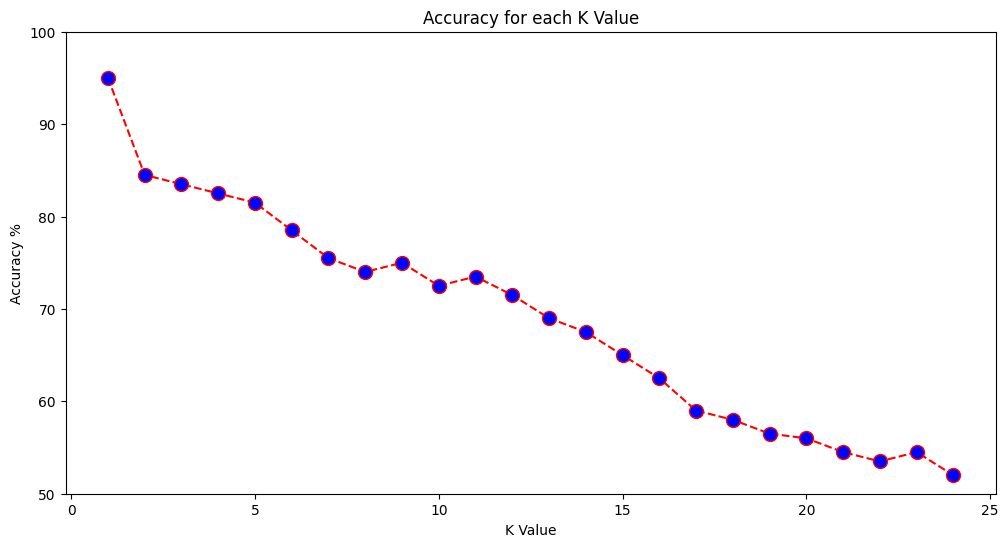

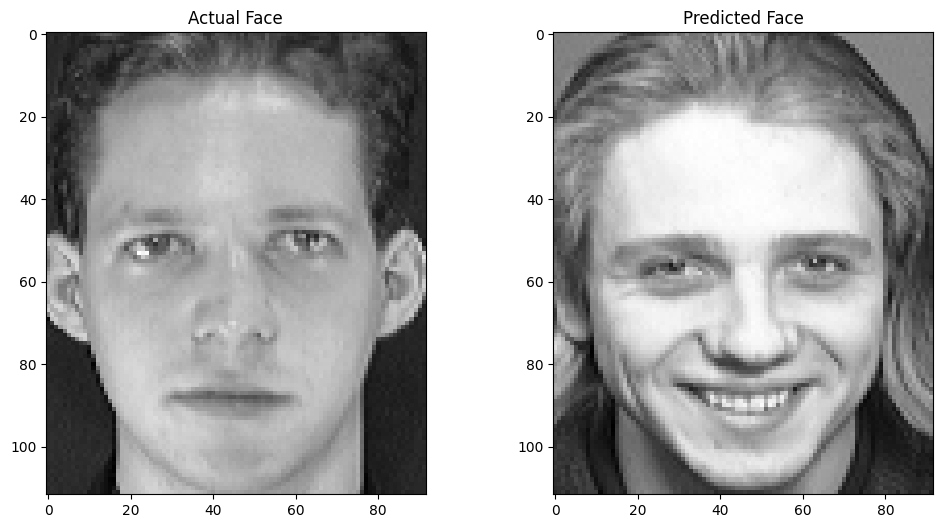

In [4]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy
from sklearn.neighbors import KNeighborsClassifier
import warnings
warnings.simplefilter("ignore")

# 读取图像数据和标签
def read_images():
    file_name = "att_faces"
    data_directory = ""+file_name
    
    data = np.zeros((400,10304))
    labels = np.zeros((400,1)) 
    
    i=0
    for name in os.listdir(data_directory):
        folderPath = os.path.join(data_directory,name)
        for ImageName in os.listdir(folderPath):
            Image_path = os.path.join(folderPath,ImageName)
            
            img = cv2.imread(Image_path,0)
            data[i,:] = img.flatten()
            labels[i] =  int(name)
            i+=1
    return data,labels

# 划分训练集和测试集
def train_test_split(data,labels):
    train_split_value = int(data.shape[0]*(5/10))
    test_split_value = data.shape[0] - train_split_value
    
    train_data = np.zeros((train_split_value,10304))
    train_labels = np.zeros((train_split_value,1)) 
    
    test_data = np.zeros((test_split_value,10304))
    test_labels = np.zeros((test_split_value,1))
    
    # odd rows for train data, even rows for test data
    i_train=0
    i_test=0
    for i in range(data.shape[0]):
        # even
        if i%2==0:
           test_data[i_test,:] = data[i]
           test_labels[i_test] = labels[i]
           i_test+=1
        # odd
        else:
           train_data[i_train,:] = data[i]
           train_labels[i_train] = labels[i]
           i_train+=1
           
    return train_data,train_labels,test_data,test_labels

# 计算每个类别的均值矩阵
def compute_classes_mean_matrix(train_data,train_labels):
    means = np.zeros((40,10304)) 
    train_test_split_ratio = 5
    
    for i in range(1,41):
        temp = np.where(train_labels == i)[0]
        temp_sum = np.zeros((1,10304)) 
        for j in range (train_test_split_ratio):
           temp_sum += train_data[temp[j],:]        
            
        means[i-1,:] = temp_sum / train_test_split_ratio
    return means

# 计算整体均值矩阵
def compute_overall_mean_matrix(classes_means):
    temp_sum = np.zeros((1,10304)) 
    for i in range(0,40):
        temp_sum +=classes_means[i,:]
    overall_mean = temp_sum / 40
    
    return overall_mean.T

# 计算类间散布矩阵
def compute_between_class_scatter_matrix(classes_means,overall_mean):
    n=5
    Sb = np.zeros((classes_means.shape[1],classes_means.shape[1]))
    for i in range(classes_means.shape[0]):
        Sb = np.add(Sb,n* ((classes_means[i] - overall_mean) * (classes_means[i] - overall_mean).T))
    return Sb

# 初始化中心类别矩阵
def compute_center_class_matrix(train_data,train_labels,classes_means):
    Z = np.zeros(train_data.shape)
    
    for i in range(train_data.shape[0]):
        Z[i,:] = train_data[i,:] - classes_means[int(train_labels[i])-1,:]

    return Z  

# 计算类内散布矩阵
def compute_class_scatter_matrix(Z):
    S = np.zeros((10304,10304))
    S = np.dot(Z.T,Z)
    return S  

# 数据降维
def data_dimencionality_reduction(train_data,test_data):
    train_data_dimensionally_reductuted = np.zeros((200,40)) 
    test_data_dimensionally_reductuted = np.zeros((200,40)) 
    
    i=0
    for img in train_data:
        train_data_dimensionally_reductuted[i,:]=np.dot(img,eigen_vectors)
        i+=1
    i=0
    for img in test_data:
        test_data_dimensionally_reductuted[i,:] = np.dot(img,eigen_vectors)
        i+=1
        
    return train_data_dimensionally_reductuted,test_data_dimensionally_reductuted

# 绘制准确率图表
def plot_accuracy_graph(accuracy):
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, 25), accuracy, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
    plt.ylim(50, 100)
    plt.title('Accuracy for each K Value')
    plt.xlabel('K Value')
    plt.ylabel('Accuracy %')
    plt.show()

if __name__ == '__main__':
    
    data, labels = read_images()
    print('Done images reading')
    print('-----------------------------------------------------------')
    
    train_data, train_labels, test_data, test_labels = train_test_split(data, labels)
    
    print('Done Train Test Split')
    print('-----------------------------------------------------------')
    
    classes_means = compute_classes_mean_matrix(train_data, train_labels)
    print('Done classes means computing')
    print('-----------------------------------------------------------')
    
    overall_mean = compute_overall_mean_matrix(classes_means)
    print('Done overall mean computing')
    print('-----------------------------------------------------------')
    
    S_between = compute_between_class_scatter_matrix(classes_means, overall_mean)
    print('Done between class scater matrix computing')
    print('-----------------------------------------------------------')
    
    Z = compute_center_class_matrix(train_data, train_labels, classes_means)
    print('Done center class scatter matrix computing')
    print('-----------------------------------------------------------')
    
    S_classes = compute_class_scatter_matrix(Z)
    print('Done within class scatter matrix computing')
    print('-----------------------------------------------------------')
    
    W_value = np.dot(np.linalg.inv(S_classes), S_between)
    print('Done W = S^(-1)B computing')
    print('-----------------------------------------------------------')
    
    eigen_values, eigen_vectors = scipy.linalg.eigh(W_value, eigvals=((10304-40),(10304-1)))
    print('Done eigen values and vectors computing')
    print('-----------------------------------------------------------')
    
    train_data_dimensionally_reductuted, test_data_dimensionally_reductuted = data_dimencionality_reduction(train_data, test_data)
    
    
    accuracy = []
    for i in range(1, 25):
        classifier = KNeighborsClassifier(n_neighbors=i)
        classifier.fit(train_data_dimensionally_reductuted, train_labels)
    
        test_predict = classifier.predict(test_data_dimensionally_reductuted)
        
        true_predicted_count=0
        for j in range(0,200):
            if test_predict[j] ==test_labels[j]:
                true_predicted_count+=1
        accuracy.append((true_predicted_count/200)*100)
    
    plot_accuracy_graph(accuracy)
    
    # 输出脸部图像分类识别结果对比
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(test_data[0].reshape((112, 92)), cmap='gray')
    axes[0].set_title('Actual Face')
    axes[1].imshow(train_data[int(test_predict[0]) - 1].reshape((112, 92)), cmap='gray')
    axes[1].set_title('Predicted Face')
    plt.show()

